###### based on https://github.com/atong01/conditional-flow-matching/blob/main/notebooks/training-8gaussians-to-moons.ipynb

# Conditional Flow Matching

This notebook is a self-contained example of conditional flow matching. We implement a number of different simulation-free methods for learning flow models. They differ based on the interpolant used and the loss function used to train them.

In this notebook we implement 5 models that can map from a source distribution $q_0$ to a target distribution $q_1$:
* Conditional Flow Matching (CFM)
    * This is equivalent to the basic (non-rectified) formulation of "Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow" [(Liu et al. 2023)](https://openreview.net/forum?id=XVjTT1nw5z)
    * Is similar to "Stochastic Interpolants" [(Albergo et al. 2023)](https://openreview.net/forum?id=li7qeBbCR1t) with a non-variance preserving interpolant.
    * Is similar to "Flow Matching" [(Lipman et al. 2023)](https://openreview.net/forum?id=PqvMRDCJT9t) but conditions on both source and target.
* Optimal Transport CFM (OT-CFM), which directly optimizes for dynamic optimal transport
* Schrödinger Bridge CFM (SB-CFM), which optimizes for Schrödinger Bridge probability paths
* "Building Normalizing Flows with Stochastic Interpolants" [(Albergo et al. 2023)](https://openreview.net/forum?id=li7qeBbCR1t) this corresponds to "VP-CFM" in our README referring to its variance preserving properties.
* "Action Matching: Learning Stochastic Dynamics From Samples" [(Neklyudov et al. 2022)](https://arxiv.org/abs/2210.06662)

Note that this Flow Matching is different from the Generative Flow Network Flow Matching losses. Here we specifically regress against continuous flows, rather than matching inflows and outflows.

In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from sklearn.datasets import make_moons

# import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-10-13 14:02:33.000032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 14:02:33.906200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys

sys.path.append("../")
from src.models.components.epic import EPiC_encoder

In [3]:
# Implement some helper functions


def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_moons(n, num_points=30):
    # x0, _ = generate_moons(n, noise=0.2)
    # return x0 * 3 - 1
    data = []
    for _ in range(n):
        x, _ = make_moons(n_samples=num_points, noise=0.05, shuffle=True)
        data.append(x)
    return torch.tensor(np.array(data), dtype=torch.float32) * 3 - 1


def sample_8gaussians(n, num_points=30):
    data = []
    for _ in range(n):
        x = eight_normal_sample(num_points, 2, scale=5, var=0.1).float()
        data.append(np.array(x))
    return torch.tensor(np.array(data), dtype=torch.float32)


class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class GradModel(torch.nn.Module):
    def __init__(self, action):
        super().__init__()
        self.action = action

    def forward(self, x):
        x = x.requires_grad_(True)
        grad = torch.autograd.grad(torch.sum(self.action(x)), x, create_graph=True)[0]
        return grad[:, :-1]


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return self.model(torch.cat([x, t.repeat(x.shape[:-1])[..., None]], dim=-1))


class torch_wrapper_epic(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        x_local = torch.cat([x, t.repeat(x.shape[:-1])[..., None]], dim=-1)
        x_global = torch.randn_like(torch.ones(x_local.shape[0], 16, device=x_local.device))
        return self.model(t, x_local)

           # "#B6BFC3",
           # "#3B515B",
           # "#0271BB",
           # "#E2001A",
def plot_trajectories(traj):
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, :, 0], traj[0, :n, :, 1], s=10, alpha=0.8, c="#0271BB")
    plt.scatter(traj[:, :n, :, 0], traj[:, :n, :, 1], s=0.2, alpha=0.2, c="#B6BFC3")
    plt.scatter(traj[-1, :n, :, 0], traj[-1, :n, :, 1], s=4, alpha=1, c="#E2001A")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
moons = sample_moons(100)
print(moons.shape)
gaussians = sample_8gaussians(100)
print(gaussians.shape)

torch.Size([100, 30, 2])
torch.Size([100, 30, 2])


In [5]:
t = torch.tensor(0.0)
rep = t.repeat(moons.shape[:-1])[..., None]
cat = torch.cat([moons, rep], dim=-1)
print(cat.shape)

torch.Size([100, 30, 3])


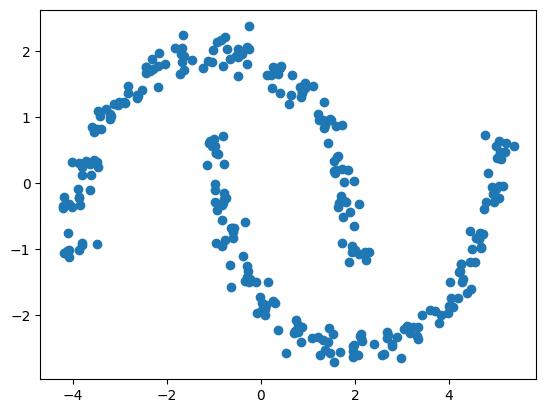

In [6]:
plt.scatter(moons[:10, :, 0], moons[:10, :, 1])
plt.show()

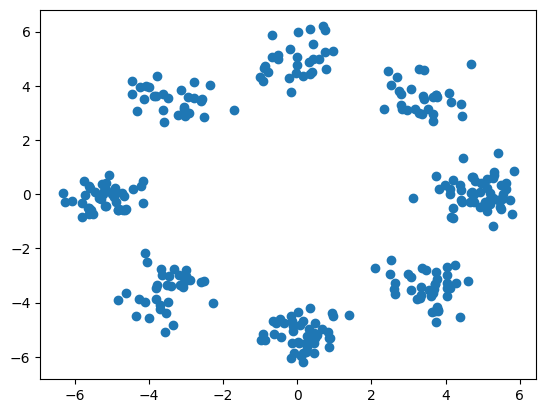

In [7]:
plt.scatter(gaussians[:10, :, 0], gaussians[:10, :, 1])
plt.show()

### Conditional Flow Matching

First we implement the basic conditional flow matching. As in the paper, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
When $\sigma = 0$ this is equivalent to zero-steps of rectified flow. We find that small $\sigma$ helps to regularize the problem ymmv.

In [8]:
from tqdm.notebook import tqdm

In [9]:
def calc_set_feats(tensor: torch.Tensor) -> torch.Tensor:
    if len(tensor.shape) != 3:
        raise ValueError("Input tensor must be of shape (batch, set_size, feats)")
    mean_set = torch.mean(tensor, dim=-2)
    sum_set = torch.sum(tensor, dim=-2)
    mean_feat = torch.mean(tensor, dim=-1)
    mean_set_feat = torch.mean(mean_feat, dim=-1).unsqueeze(-1)
    sum_set_feat = torch.sum(mean_feat, dim=-1).unsqueeze(-1)
    cat = torch.cat([mean_set, sum_set, mean_set_feat, sum_set_feat], dim=-1)
    return cat

## Lipman Flow Matching

In [10]:
%%time

steps = 500
sigma = 1e-4
dim = 2
batch_size = 1024
# model = MLP(dim=dim, time_varying=True)
model = EPiC_encoder(feats=dim, input_dim=dim + 1)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
data = sample_moons(batch_size * 10)  # data
for k in tqdm(range(steps)):
    optimizer.zero_grad()
    # x = sample_8gaussians(batch_size)

    subset = torch.randint(0, len(data), (batch_size,))
    x = data[subset]

    # print(f"X shape: {x.shape}")
    t = torch.rand_like(torch.ones(x.shape[0]))
    t = t.unsqueeze(-1).repeat_interleave(x.shape[1], dim=1).unsqueeze(-1)
    t = t.type_as(x)
    # print(f"t shape: {t.shape}")
    # print(f"t shape: {t[:2]}")

    z = torch.randn_like(x)
    # print(f"z shape: {z.shape}")

    y = (1 - t) * x + (sigma + (1 - sigma) * t) * z
    # print(f"y shape: {y.shape}")
    ut = (1 - sigma) * z - x
    # print(f"ut shape: {ut.shape}")
    # frequencies = 6
    # print(f"t shape: {t.shape}")
    # print(f"tsqueeze shape: {t.squeeze().shape}")
    # t = t.squeeze(-1)
    # print(f"t shape: {t.shape}")
    # t = frequencies * t[..., None]
    # print(f"t shape: {t.shape}")
    # t = torch.cat((t.cos(), t.sin()), dim=-1)
    # print(f"t shape: {t.shape}")
    # t = t.expand(*x.shape[:-1], -1)
    # print(f"t shape: {t.shape}")
    x_local = torch.cat([x, t], dim=-1)
    x_global = torch.randn_like(torch.ones(x_local.shape[0], 16, device=x_local.device))
    vt = model(t, x_local)

    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()
    # if (k + 1) % 30 == 0:
    #    print(f"k: {k+1}")
    if (k + 1) % 100 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper_epic(model),
            solver="midpoint",
            sensitivity="adjoint",
        )
        with torch.no_grad():
            traj = node.trajectory(
                torch.randn_like(x)[:100],
                t_span=torch.linspace(1.0, 0.0, 50),
            )
            plt.scatter(traj[-1:, :, 0], traj[-1:, :, 1])
            plt.show()
            plot_trajectories(traj)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

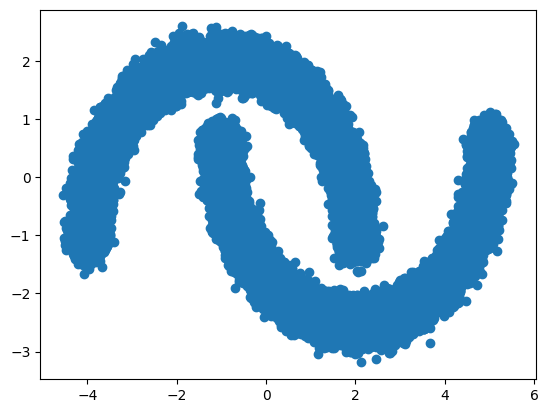

In [ ]:
plt.scatter(data[:, :, 0], data[:, :, 1])
plt.show()

# Self conditioned model

  0%|          | 0/1000 [00:00<?, ?it/s]

1: loss 17.515 time 0.57


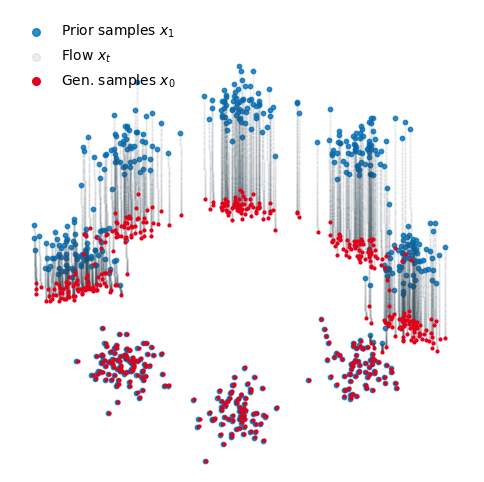

50: loss 13.832 time 30.93


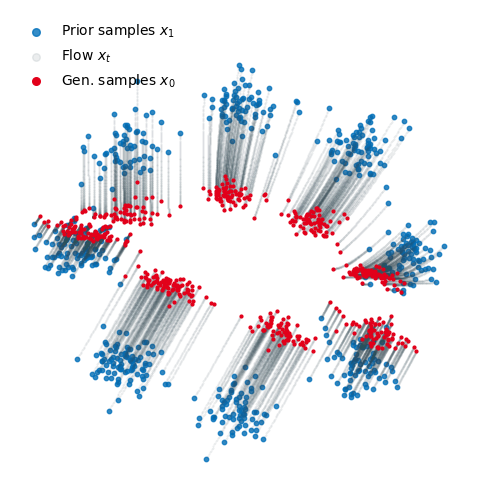

100: loss 13.708 time 31.44


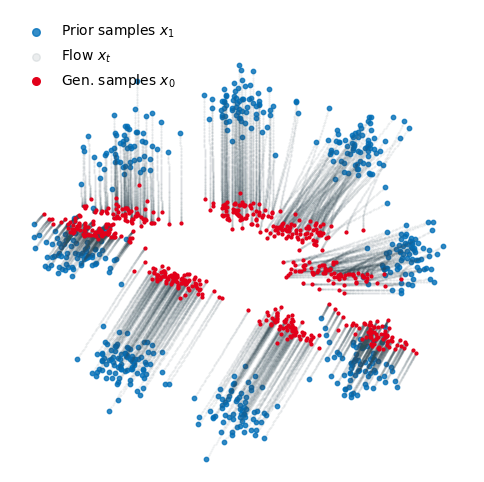

150: loss 12.762 time 31.50


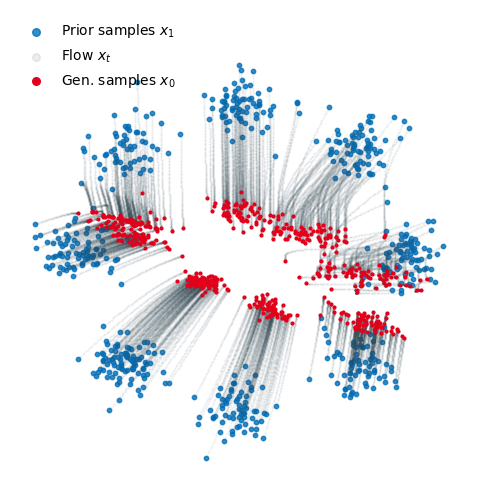

200: loss 12.197 time 31.01


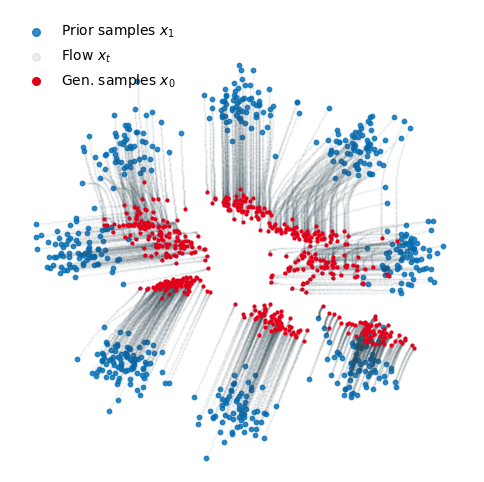

250: loss 12.832 time 31.25


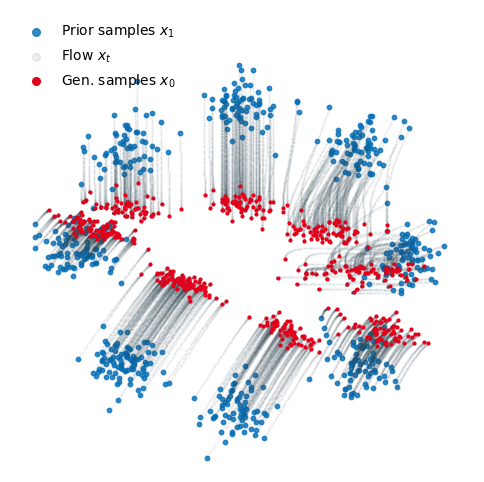

300: loss 12.594 time 31.07


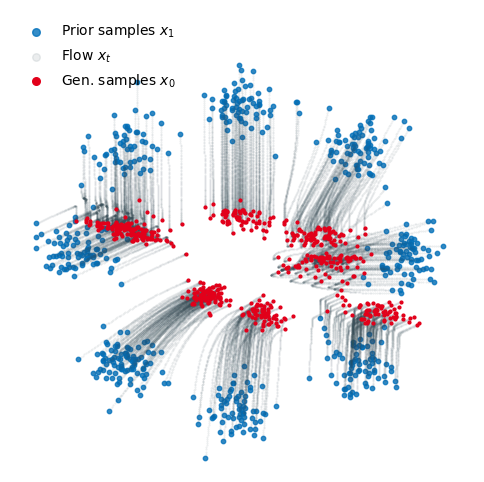

350: loss 11.569 time 30.96


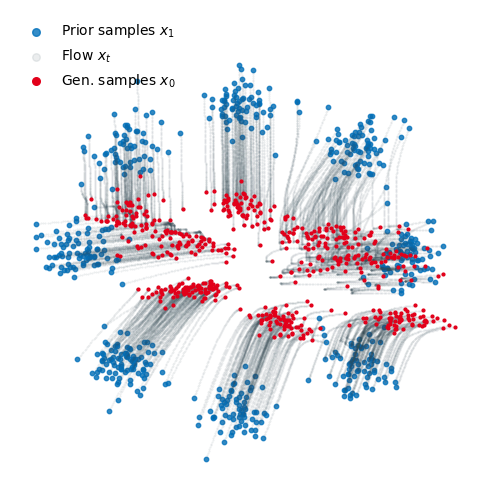

400: loss 11.620 time 30.72


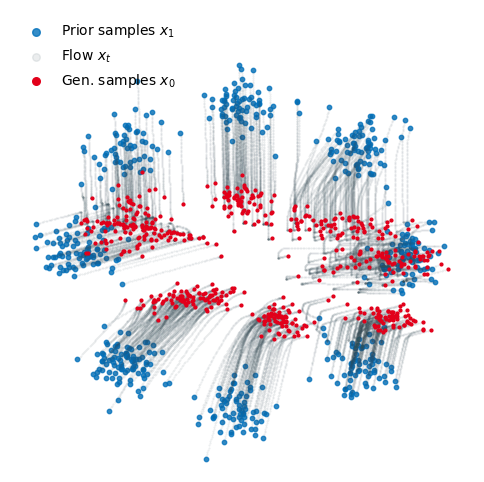

450: loss 11.210 time 30.92


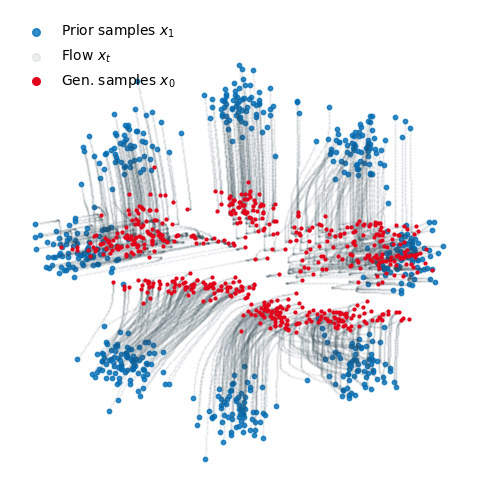

500: loss 11.088 time 31.20


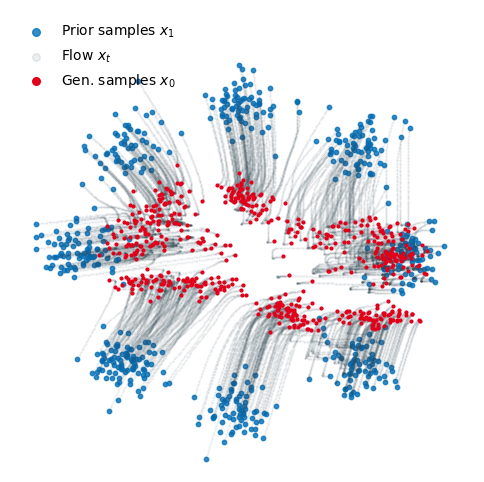

550: loss 10.767 time 30.89


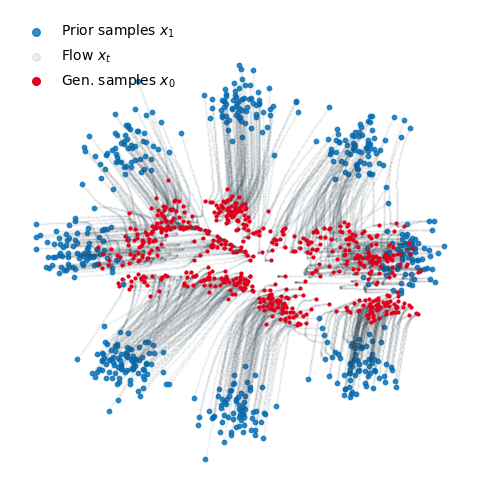

600: loss 11.192 time 31.20


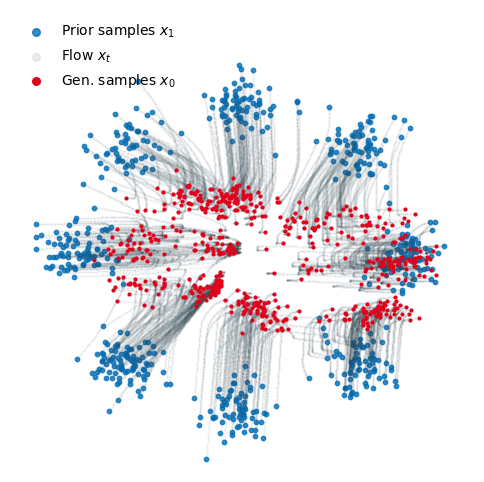

650: loss 10.390 time 30.74


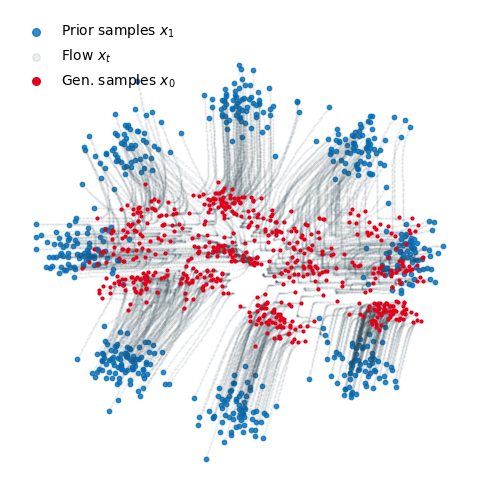

700: loss 10.095 time 30.71


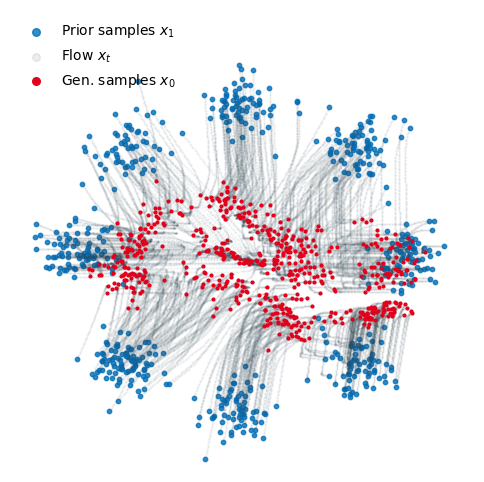

750: loss 9.852 time 30.27


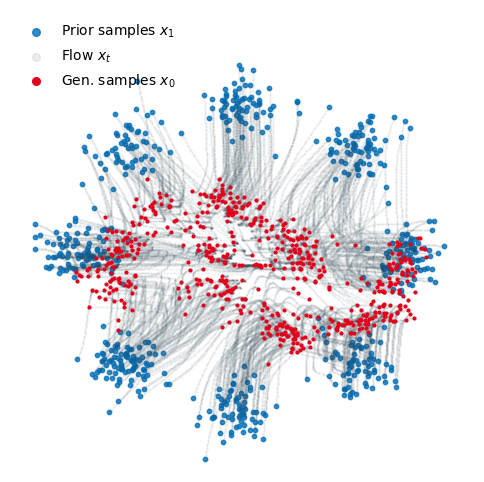

800: loss 9.108 time 29.55


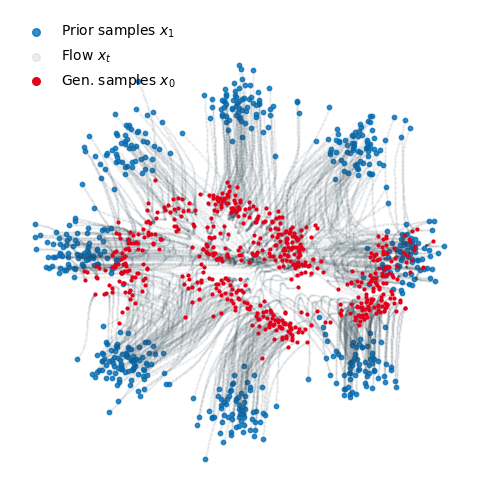

850: loss 8.963 time 29.82


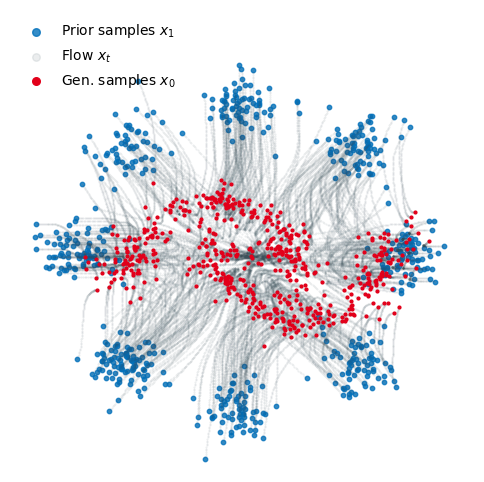

900: loss 9.005 time 31.43


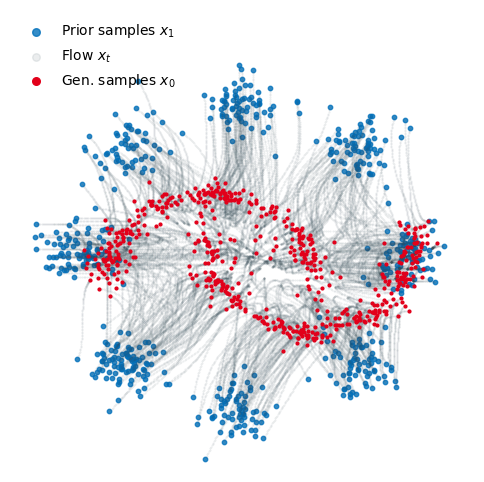

950: loss 8.599 time 31.13


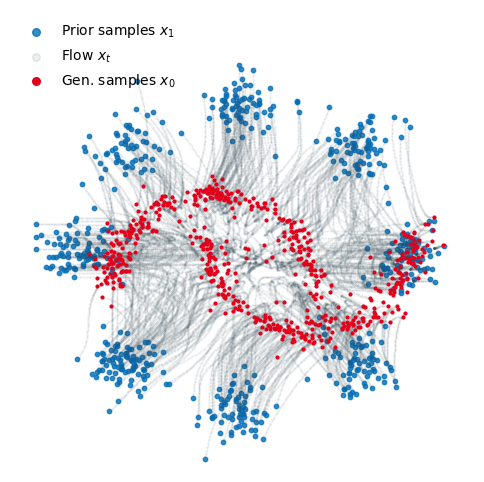

1000: loss 8.533 time 31.07


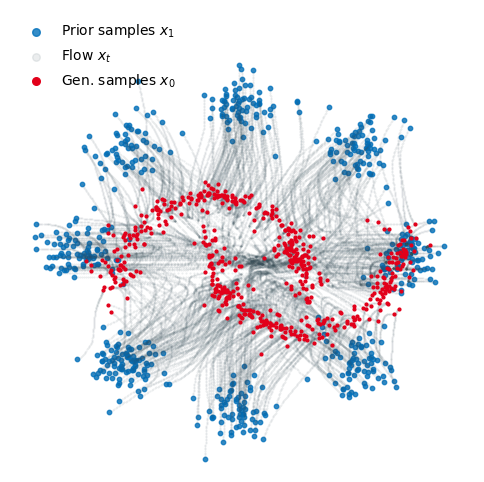

CPU times: user 10h 2min 57s, sys: 15.9 s, total: 10h 3min 13s
Wall time: 10min 22s


In [147]:
%%time

steps = 1000
sigma = 0.1
dim = 2
batch_size = 256
# model = MLP(dim=dim, time_varying=True)
model = EPiC_encoder(feats=dim, input_dim=dim + 1 + 2)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in tqdm(range(steps)):
    optimizer.zero_grad()
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t = torch.rand_like(torch.ones(x0.shape[0]))
    t = t.unsqueeze(-1).repeat_interleave(x0.shape[1], dim=1).unsqueeze(-1)
    t = t.type_as(x0)
    
    s = torch.rand(1)

    #print(f"s: {s}")

    mu_t = (1 - t) * x1 + t * x0

    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn_like(x0)

    ut = x0 - x1

    #print(f"x shape: {x.shape}")
    x_local = torch.cat([x, (t)], dim=-1)
    #print(f"x_local shape: {x_local.shape}")
    


    x_1_tilde = sample_8gaussians(batch_size)
    #print(x_local.shape)
    #print(x_1_tilde.shape)
    if s > 0.5:
        x_local2 = torch.cat([x_local, x_1_tilde], dim=-1)
        #print(f"x_local shape: {x_local2.shape}")
        x_1_tilde = model(t, x_local2, x_1_tilde)

    
    x_global = torch.randn_like(torch.ones(x_local.shape[0], 16, device=x_local.device))
    #print(x_local.shape)
    #print(x_global.shape)
    x_local = torch.cat([x_local, x_1_tilde], dim=-1)
    vt = model(t, x_local)

    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()
    # if (k + 1) % 30 == 0:
    #    print(f"k: {k+1}")
    if (k + 1) % 50 == 0 or k == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        with torch.no_grad():
            torch.manual_seed(0)
            zss = sample_8gaussians(20)
            xss,traj = esampler_selfcond(torch_wrapper_epic_selfcond(model, zss), zss)
        #plt.scatter(xss[:, :, 0], xss[:, :, 1])
        plot_trajectories(traj, n=20, save_name=f"pictures/{k+1}")
        #plt.savefig(f"pictures/{k+1}.png")
        #plt.show()
        
        #node = NeuralODE(
        #    torch_wrapper_epic(model),
        #    solver="midpoint",
        #    sensitivity="adjoint",
        #    atol=1e-4,
        #    rtol=1e-4,
        ##)
        #with torch.no_grad():
        #    traj = node.trajectory(
        #        sample_8gaussians(100),
        #        t_span=torch.linspace(1.0, 0.0, 50),
        #    )
        #    plot_trajectories(traj)
# torch.save(model, f"{savedir}/cfm_v1.pt")

In [58]:
class torch_wrapper_epic_selfcond(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model, cond):
        super().__init__()
        self.model = model
        self.cond = cond

    def forward(self, t, x, cond, *args, **kwargs):
        x_local = torch.cat([x, t.repeat(x.shape[:-1])[..., None]], dim=-1)
        x_global = torch.randn_like(torch.ones(x_local.shape[0], 16, device=x_local.device))
        if cond is None:
            x_local = torch.cat([x_local, self.cond], dim=-1)
        else: 
            x_local = torch.cat([x_local, cond], dim=-1)
        return self.model(t, x_local)

In [ ]:
def esampler(func, noise, steps=50):
    t = torch.ones(1)
    delta_t = 1 / steps
    for _ in range(steps):
        # print(f"t: {t}")
        noise += -func(t, noise) * delta_t
        t -= delta_t
    return noise

In [131]:
def esampler_selfcond(func, noise, steps=100):
    traj_arr = []
    t = torch.ones(1)
    delta_t = 1 / steps
    for _ in range(steps):
        # print(f"t: {t}")
        #print(noise.shape)
        #print(cond.shape)
        #noise = torch.cat([noise, cond], dim=-1)
        #print(noise.shape)
        #cond = noise.clone()
        #print(cond.shape)
        if t == 1:
            #print(f"t: {t}")
            cond = -func(t, noise, None) 
            noise += cond * delta_t
        else:
            #print(f"t: {t}")
            cond = -func(t, noise, cond)
            noise += cond * delta_t
            #cond = noise.clone()
        t -= delta_t
        #plt.scatter(noise[:, :, 0], noise[:, :, 1])
        #plt.show()
        #print(noise.shape)
        traj_arr.append(noise.clone().numpy())
    return noise, np.array(traj_arr)

In [132]:
with torch.no_grad():
    zss = sample_8gaussians(100)
    xss, traj = esampler_selfcond(torch_wrapper_epic_selfcond(model, zss), zss)

In [133]:
print(np.array(traj).shape)

(100, 100, 30, 2)


In [143]:
def plot_trajectories(traj, n=20, save_name="test"):
    plt.figure(figsize=(6, 6))
    plt.xlim(-7, 7)
    plt.ylim(-7, 8)
    plt.scatter(traj[0, :n, :, 0], traj[0, :n, :, 1], s=10, alpha=0.8, c="#0271BB", label="Prior samples $x_1$")
    plt.scatter(traj[:, :n, :, 0], traj[:, :n, :, 1], s=0.2, alpha=0.1, c="#3B515B", label="Flow $x_t$")
    plt.scatter(traj[-1, :n, :, 0], traj[-1, :n, :, 1], s=4, alpha=1, c="#E2001A", label="Gen. samples $x_0$")
    legend = plt.legend(frameon=False, loc="upper left")
    #plt.xticks([])
    #plt.yticks([])
    legend.legend_handles[0]._sizes = [30]
    legend.legend_handles[1]._sizes = [30]
    legend.legend_handles[2]._sizes = [30]
    
    plt.savefig(f"{save_name}.pdf", bbox_inches="tight")
    plt.axis("off")
    plt.show()

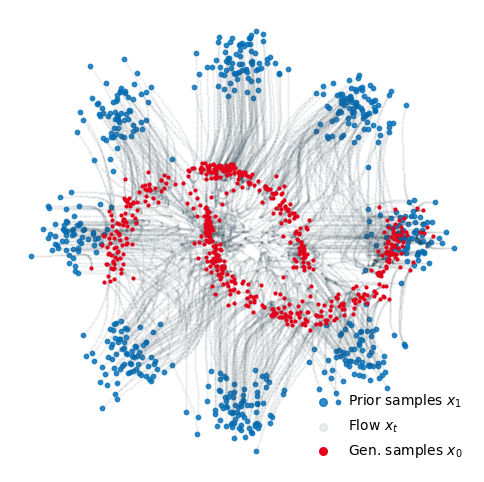

In [135]:
plot_trajectories(traj)

In [86]:
print(xss.shape)

torch.Size([100, 30, 2])


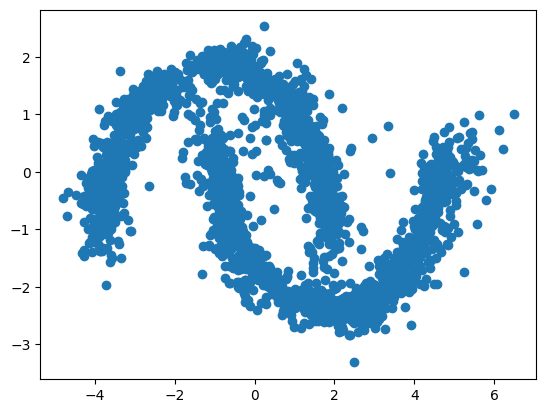

In [110]:
plt.scatter(xss[:, :, 0], xss[:, :, 1])
plt.show()

## Conditional Flow Matching

  0%|          | 0/200 [00:00<?, ?it/s]

50: loss 14.017 time 16.50


/home/ewencedr/.conda/envs/pllhome/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


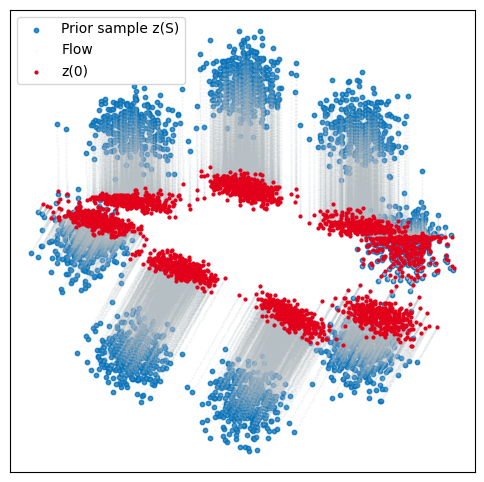

100: loss 13.568 time 19.56


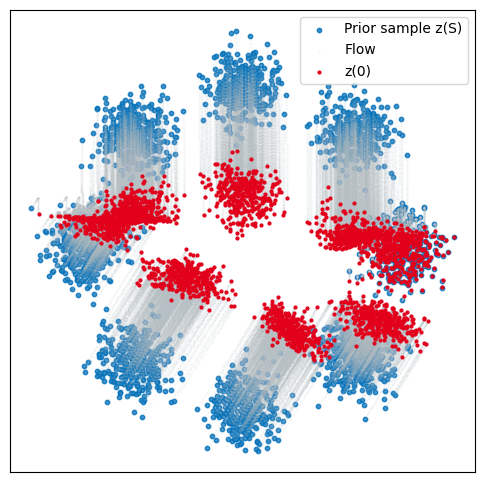

150: loss 12.290 time 20.03


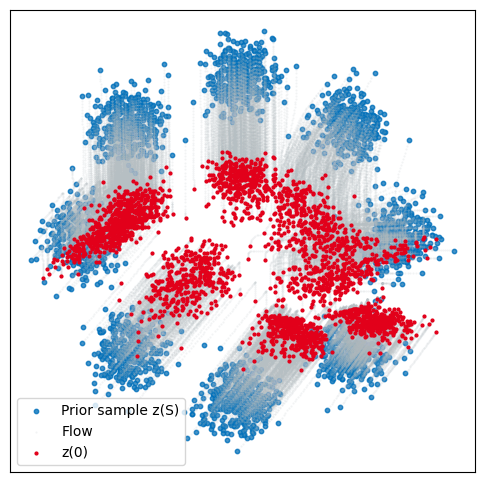

200: loss 13.236 time 21.65


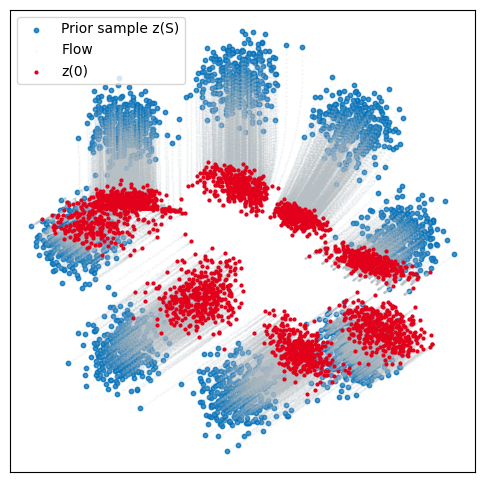

CPU times: user 1h 13min 34s, sys: 1.8 s, total: 1h 13min 36s
Wall time: 1min 22s


In [24]:
%%time

steps = 200
sigma = 0.1
dim = 2
batch_size = 256
# model = MLP(dim=dim, time_varying=True)
model = EPiC_encoder(feats=dim, input_dim=dim + 1)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in tqdm(range(steps)):
    optimizer.zero_grad()
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t = torch.rand_like(torch.ones(x0.shape[0]))
    t = t.unsqueeze(-1).repeat_interleave(x0.shape[1], dim=1).unsqueeze(-1)
    t = t.type_as(x0)

    mu_t = (1 - t) * x1 + t * x0

    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn_like(x0)

    ut = x0 - x1

    x_local = torch.cat([x, (t)], dim=-1)
    x_global = torch.randn_like(torch.ones(x_local.shape[0], 16, device=x_local.device))
    #print(x_local.shape)
    #print(x_global.shape)
    vt = model(t, x_local)

    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()
    # if (k + 1) % 30 == 0:
    #    print(f"k: {k+1}")
    if (k + 1) % 50 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper_epic(model),
            solver="midpoint",
            sensitivity="adjoint",
            atol=1e-4,
            rtol=1e-4,
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(100),
                t_span=torch.linspace(1.0, 0.0, 50),
            )
            plot_trajectories(traj)
# torch.save(model, f"{savedir}/cfm_v1.pt")

In [25]:
def esampler_sc(func, noise, steps=50):
    t = torch.ones(1)
    delta_t = 1 / steps
    for _ in range(steps):
        # print(f"t: {t}")
        noise += -func(t, noise) * delta_t
        t -= delta_t
    return noise

In [31]:
with torch.no_grad():
    zss = sample_8gaussians(100)
    xss = esampler(torch_wrapper_epic(model), zss)

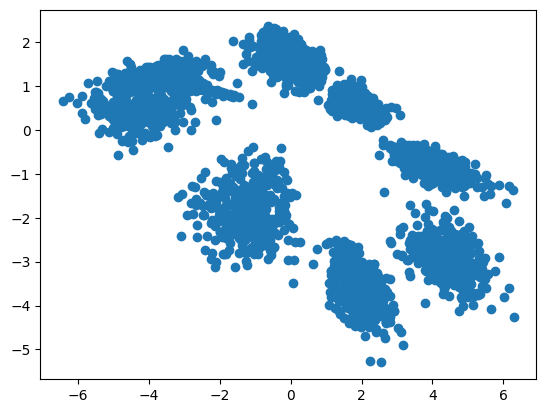

In [32]:
plt.scatter(xss[:, :, 0], xss[:, :, 1])
plt.show()

In [ ]:
ss = esampler(torch_wrapper_epic(model), )

In [42]:
with torch.no_grad():
    traj = node.trajectory(
        sample_8gaussians(100),
        t_span=torch.linspace(1.0, 0.0, 100),
    )

/home/ewencedr/.conda/envs/pllhome/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


In [52]:
with torch.no_grad():
    traj0 = node0.trajectory(
        sample_8gaussians(100),
        t_span=torch.linspace(1.0, 0.0, 100),
    )

/home/ewencedr/.conda/envs/pllhome/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


In [56]:
           # "#B6BFC3",
           # "#3B515B",
           # "#0271BB",
           # "#E2001A",
def plot_trajectories(traj, n=10, save_name="test"):
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, :, 0], traj[0, :n, :, 1], s=10, alpha=0.8, c="#0271BB", label="Prior samples $x_1$")
    plt.scatter(traj[:, :n, :, 0], traj[:, :n, :, 1], s=0.2, alpha=0.1, c="#3B515B", label="Flow $x_t$")
    plt.scatter(traj[-1, :n, :, 0], traj[-1, :n, :, 1], s=4, alpha=1, c="#E2001A", label="Gen. samples $x_0$")
    legend = plt.legend(frameon=False)
    #plt.xticks([])
    #plt.yticks([])
    legend.legend_handles[0]._sizes = [30]
    legend.legend_handles[1]._sizes = [30]
    legend.legend_handles[2]._sizes = [30]
    
    plt.savefig(f"{save_name}.pdf", bbox_inches="tight")
    plt.axis("off")
    plt.show()

In [17]:
print(traj.shape)

torch.Size([50, 100, 30, 2])


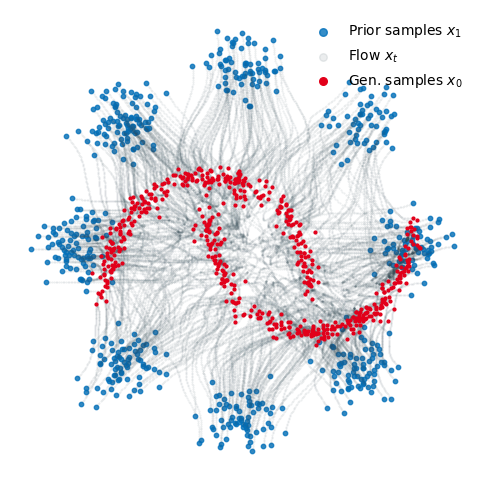

In [58]:
plot_trajectories(traj, n=20, save_name="cfm")

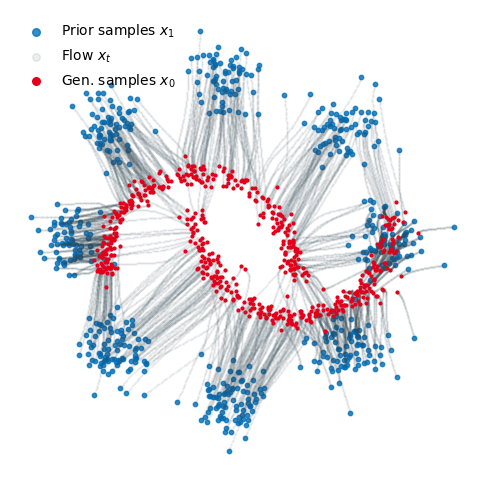

In [59]:
plot_trajectories(traj0, n=20, save_name="cfm_ot")

### Optimal Transport Conditional Flow Matching

Next we implement optimal transport conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi(x_0, x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
where $\pi$ is the joint of an exact optimal transport matrix. We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with dynamic optimal transport.

  0%|          | 0/2000 [00:00<?, ?it/s]

500: loss 0.661 time 199.77


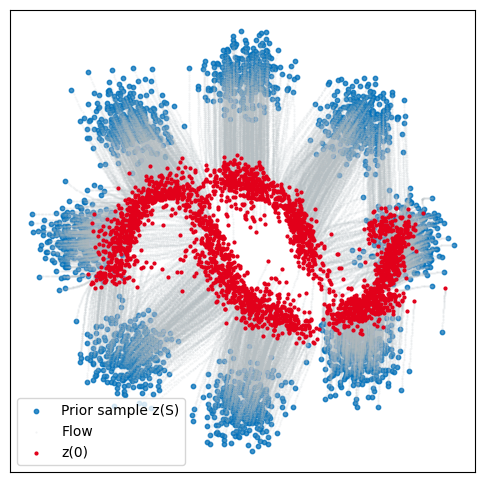

1000: loss 0.633 time 203.36


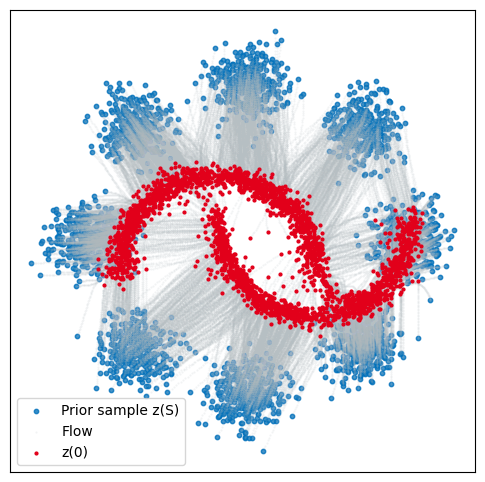

1500: loss 0.612 time 207.78


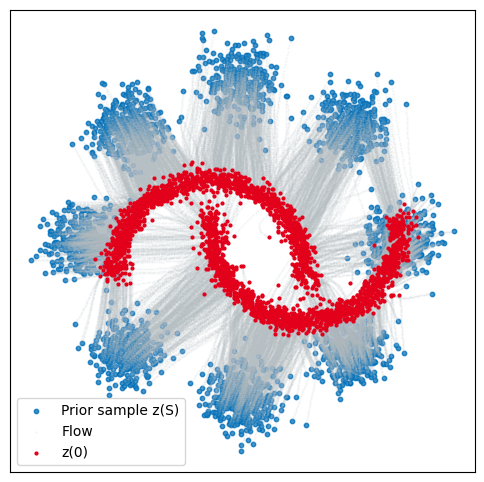

2000: loss 0.546 time 205.41


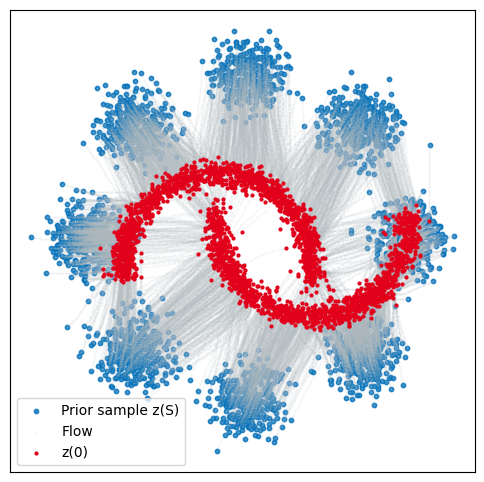

CPU times: user 10h 39min 14s, sys: 2min 5s, total: 10h 41min 19s
Wall time: 13min 41s


In [13]:
%%time

sigma = 0.1
dim = 2
batch_size = 256
# model = MLP(dim=dim, time_varying=True)
model = EPiC_encoder(feats=dim) #latent_local=dim + 1)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for z in tqdm(range(2000)):
    optimizer.zero_grad()
    x0 = sample_8gaussians(batch_size)  # (x,y)
    x1 = sample_moons(batch_size)  # (x,y)
    #print(f"x_0: {x0.shape}")
    # print(f"x_1: {x1.shape}")

    t = torch.rand_like(torch.ones(x0.shape[0]))
    t = t.unsqueeze(-1).repeat_interleave(x0.shape[1], dim=1).unsqueeze(-1)
    t = t.type_as(x0)

    a, b = pot.unif(x0.size()[1]), pot.unif(x1.size()[1])
    a = np.repeat(np.expand_dims(a, axis=0), x0.size()[0], axis=0)
    b = np.repeat(np.expand_dims(b, axis=0), x1.size()[0], axis=0)
    # print(f"a: {a}")
    M = torch.cdist(x0, x1) ** 2
    # M = M / M.max()
    # M2 = torch.nn.functional.normalize(M, dim=1)
    # print(f"M2: {M2.shape}")
    # print(f"M: {M.shape}")
    # print(M2-M)
    # print(f"a.shape: {a.shape}")
    # print(f"M.shape: {M.shape}")
    # pi = []
    # print(f"x0: {x0.shape}")
    # print(f"x1: {x1.shape}")
    for k in range(M.shape[0]):
        M[k] = M[k] / M[k].max()
        pi = pot.emd(a[k], b[k], M[k].detach().cpu().numpy())
        #print(f"pi: {pi.shape}")
        p = pi.flatten()
        #print(f"p: {p.shape}")
        p = p / p.sum()
        choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=pi.shape[0])
        #print(f"choices: {choices.shape}")
        i, j = np.divmod(choices, pi.shape[1])
        #print(f"i   : {i}")
        #print(f"j   : {j}")
        x0[k] = x0[k, i]
        x1[k] = x1[k, j]
        # pi.append(pi_temp)

    # pi = np.array(pi)
    # print(f"pi: {pi.shape}")

    # Sample random interpolations on pi
    # p = pi.reshape(pi.shape[0], -1)
    # p = p / p.sum()
    # choices = []
    # for i in range(p.shape[0]):
    #    p[i] = p[i] / p[i].sum()
    #    choices_temp = np.random.choice(pi.shape[1] * pi.shape[2], p=p[i], size=pi.shape[1])
    #    choices.append(choices_temp)
    # choices = np.array(choices)
    # print(f"choices: {choices.shape}")

    # i, j = np.divmod(choices, pi.shape[2])
    # print(f"i: {i.shape}")
    # print(f"x0: {x0.shape}")
    #
    # for k in range(i.shape[0]):
    #    x0[k] = x0[k][i[k]]
    #    x1[k] = x1[k][j[k]]
    # x0 = x0[i]
    # x1 = x1[j]
    # print("test")
    # calculate regression loss
    # print(f"x0: {x0.shape}")
    # print(f"x1: {x1.shape}")
    # print(f"t: {t.shape}")
    mu_t = x0 * t + x1 * (1 - t)
    # print(f"mu_t: {mu_t.shape}")
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn_like(x0)
    ut = x0 - x1
    x_local = torch.cat([x, t], dim=-1)
    # print(f"x_local: {x_local.shape}")
    x_global = torch.randn_like(torch.ones(x_local.shape[0], 16, device=x_local.device))
    vt = model(t, x_local)
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    # if (z + 1) % 30 == 0:
    #    print(f"z: {z+1}")
    if (z + 1) % 500 == 0:
        end = time.time()
        print(f"{z+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node0 = NeuralODE(
            torch_wrapper_epic(model),
            solver="midpoint",
            sensitivity="adjoint",
            atol=1e-4,
            rtol=1e-4,
        )
        with torch.no_grad():
            traj0 = node0.trajectory(
                sample_8gaussians(100),
                t_span=torch.linspace(1, 0, 50),
            )
            plot_trajectories(traj0)
# torch.save(model, f"{savedir}/cfm_v1.pt")

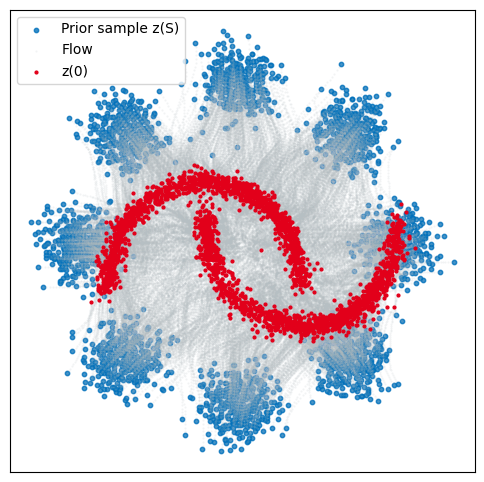

In [14]:
plot_trajectories(traj)

In [ ]:
print(traj.shape)

old slower version

time the other way around

In [12]:
%%time

sigma = 0.1
dim = 2
batch_size = 256
# model = MLP(dim=dim, time_varying=True)
model = EPiC_generator(feats=dim, latent_local=dim + 1)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for z in tqdm(range(500)):
    optimizer.zero_grad()
    x0 = sample_8gaussians(batch_size)  # (x,y)
    x1 = sample_moons(batch_size)  # (x,y)
    # print(f"x_0: {x0.shape}")
    # print(f"x_1: {x1.shape}")

    t = torch.rand_like(torch.ones(x0.shape[0]))
    t = t.unsqueeze(-1).repeat_interleave(x0.shape[1], dim=1).unsqueeze(-1)
    t = t.type_as(x0)

    a, b = pot.unif(x0.size()[1]), pot.unif(x1.size()[1])
    a = np.repeat(np.expand_dims(a, axis=0), x0.size()[0], axis=0)
    b = np.repeat(np.expand_dims(b, axis=0), x1.size()[0], axis=0)
    # print(f"a: {a}")
    M = torch.cdist(x0, x1) ** 2
    # M = M / M.max()
    # M2 = torch.nn.functional.normalize(M, dim=1)
    # print(f"M2: {M2.shape}")
    # print(f"M: {M.shape}")
    # print(M2-M)
    # print(f"a.shape: {a.shape}")
    # print(f"M.shape: {M.shape}")
    pi = []
    for k in range(M.shape[0]):
        M[k] = M[k] / M[k].max()
        pi_temp = pot.emd(a[k], b[k], M[k].detach().cpu().numpy())

        pi.append(pi_temp)

    pi = np.array(pi)
    # print(f"pi: {pi.shape}")

    # Sample random interpolations on pi
    p = pi.reshape(pi.shape[0], -1)
    # p = p / p.sum()
    choices = []
    for i in range(p.shape[0]):
        p[i] = p[i] / p[i].sum()
        choices_temp = np.random.choice(pi.shape[1] * pi.shape[2], p=p[i], size=pi.shape[1])
        choices.append(choices_temp)
    choices = np.array(choices)
    # print(f"choices: {choices.shape}")

    i, j = np.divmod(choices, pi.shape[2])
    # print(f"i: {i.shape}")
    # print(f"x0: {x0.shape}")
    #
    for k in range(i.shape[0]):
        x0[k] = x0[k][i[k]]
        x1[k] = x1[k][j[k]]
    # x0 = x0[i]
    # x1 = x1[j]
    # print("test")
    # calculate regression loss
    # print(f"x0: {x0.shape}")
    # print(f"x1: {x1.shape}")
    # print(f"t: {t.shape}")
    mu_t = x0 * (1 - t) + x1 * t
    # print(f"mu_t: {mu_t.shape}")
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn_like(x0)
    ut = x1 - x0
    x_local = torch.cat([x, t], dim=-1)
    # print(f"x_local: {x_local.shape}")
    x_global = torch.randn_like(torch.ones(x_local.shape[0], 16, device=x_local.device))
    vt = model(t, x_global, x_local)
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    # if (z + 1) % 30 == 0:
    #    print(f"z: {z+1}")
    if (z + 1) % 100 == 0:
        end = time.time()
        print(f"{z+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper_epic(model),
            solver="midpoint",
            sensitivity="adjoint",
            atol=1e-4,
            rtol=1e-4,
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(100),
                t_span=torch.linspace(0, 1, 50),
            )
            plot_trajectories(traj)
# torch.save(model, f"{savedir}/cfm_v1.pt")

NameError: name 'EPiC_generator' is not defined

### plot single trajectory

In [ ]:
print(traj.shape)

In [ ]:
def plot_trajectories1(traj):
    n = 1
    m = 2
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, :, 0], traj[0, :n, :, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, :, 0], traj[:, :n, :, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, :, 0], traj[-1, :n, :, 1], s=4, alpha=1, c="blue")
    plt.scatter(traj[0, m, :, 0], traj[0, m, :, 1], s=10, alpha=0.8, c="green")
    plt.scatter(traj[:, m, :, 0], traj[:, m, :, 1], s=0.2, alpha=0.2, c="orange")
    plt.scatter(traj[-1, m, :, 0], traj[-1, m, :, 1], s=4, alpha=1, c="red")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
plot_trajectories1(traj)

In [ ]:
tensor1 = torch.rand_like(torch.ones(10, 5, 3))
tensor2 = torch.rand_like(torch.ones(10, 5, 3))
print(tensor1.shape)

In [ ]:
# def calc_set_feats(tensor: torch.Tensor) -> torch.Tensor:
#    if len(tensor.shape) != 3:
#        raise ValueError("Input tensor must be of shape (batch, set_size, feats)")
#    mean_set = torch.mean(tensor, dim=-2)
#    sum_set = torch.sum(tensor, dim=-2)
#    mean_feat = torch.mean(tensor, dim=-1)
#    mean_set_feat = torch.mean(mean_feat, dim=-1).unsqueeze(-1)
#    sum_set_feat = torch.sum(mean_feat, dim=-1).unsqueeze(-1)
#    cat = torch.cat([mean_set, sum_set, mean_set_feat, sum_set_feat], dim=-1)
#    return cat

In [ ]:
print(f"function: {calc_set_feats(tensor1).shape}")

In [ ]:
mean_set = torch.mean(tensor1, dim=-2)
sum_set = torch.sum(tensor1, dim=-2)
print(mean_set.shape)
print(sum_set.shape)
print(f"tensor1: {tensor1.shape}")
mean_feat = torch.mean(tensor1, dim=-1)
print(mean_feat.shape)
mean_set_feat = torch.mean(mean_feat, dim=-1).unsqueeze(-1)
sum_set_feat = torch.sum(mean_feat, dim=-1).unsqueeze(-1)
print(mean_set_feat.shape)
print(sum_set_feat.shape)
cat = torch.cat([mean_set, sum_set, mean_set_feat, sum_set_feat], dim=-1)
print(cat.shape)

In [ ]:
diff = tensor1 - tensor2
print(diff.shape)
sqr = diff**2
print(sqr.shape)
mn = torch.mean(sqr)
print(mn.shape)
# loss = torch.mean((vt - ut) ** 2)

### Optimal Transport Conditional Flow Matching

Next we implement optimal transport conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi(x_0, x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
where $\pi$ is the joint of an exact optimal transport matrix. We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with dynamic optimal transport.

In [ ]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    print(x0.shape, x1.shape)
    # Resample x0, x1 according to transport matrix
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    # return uniform distribution (256 Werte alle mit dem gleichen Wert 1/256)
    # print(f"x0: {x0.size()[0]}")
    # print(a,b)

    M = torch.cdist(x0, x1) ** 2
    print(f"M shape: {M.shape}")
    print(f"M: {M}")
    M = M / M.max()

    pi = pot.emd(a, b, M.detach().cpu().numpy())
    print(f"pi shape: {pi.shape}")
    print(f"pi: {pi[0]}")

    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    print(f"P: {p}")
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    print(f"choices.shape: {choices.shape}")
    print(f"choices: {choices}")
    i, j = np.divmod(choices, pi.shape[1])
    print(f"i: {i}")
    print(f"j: {j}")
    x0 = x0[i]
    x1 = x1[j]
    # calculate regression loss
    mu_t = x0 * (1 - t) + x1 * t
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn(batch_size, dim)
    ut = x1 - x0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj)
#torch.save(model, f"{savedir}/otcfm_v1.pt")

# Other tests

In [ ]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal
from tqdm import tqdm
from zuko.utils import odeint

from src.models.components.diffusion import VPDiffusionSchedule

In [ ]:
class MLP(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: List[int] = [64, 64],
    ):
        layers = []

        for a, b in zip(
            [in_features] + hidden_features,
            hidden_features + [out_features],
        ):
            layers.extend([nn.Linear(a, b), nn.ELU()])

        super().__init__(*layers[:-1])

In [ ]:
def get_ode_gradient(
    model,
    diff_sched: VPDiffusionSchedule,
    x_t: torch.Tensor,
    t: torch.Tensor,
    mask: Optional[torch.BoolTensor] = None,
    ctxt: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    expanded_shape = [-1] + [1] * (x_t.dim() - 1)
    _, noise_rates = diff_sched(t.view(expanded_shape))
    betas = diff_sched.get_betas(t.view(expanded_shape))
    return 0.5 * betas * (x_t - model(t, x_t) / noise_rates)


class ode_wrapper(torch.nn.Module):
    """Wraps model to ode solver compatible format."""

    def __init__(self, model, mask=None, cond=None, diff_config={"max_sr": 0.999, "min_sr": 0.02}):
        super().__init__()
        self.model = model
        self.diff_sched = VPDiffusionSchedule(**diff_config)
        self.cond = cond
        self.mask = mask
        self.init = True
        self.steps = 50

    def forward(self, t, x):
        num_samples = x.shape[0]
        expanded_shape = [-1] + [1] * (x.dim() - 1)
        # print("new")
        # if self.init:
        #    print("init")
        #    self.init = False
        #    t = torch.ones(num_samples)
        #    signal_rates, noise_rates = self.diff_sched(t.view(expanded_shape))
        #    x = x * (signal_rates + noise_rates)
        #    t=torch.ones(1)
        # print(f"t: {t}")
        _, noise_rates = self.diff_sched(t.view(expanded_shape))
        betas = self.diff_sched.get_betas(t.view(expanded_shape))
        return (
            -0.5 * betas * (x - self.model(t, x) / noise_rates)
        )  # TODO add cond and mask for full version
        # return get_ode_gradient(self.model, self.diff_sched, x, t, self.mask, self.cond)
        # if self.init:
        #    self.init = False
        #    t_init = torch.ones(num_samples)
        #    signal_rates_init, noise_rates_init = self.diff_sched(t_init.view(expanded_shape))
        #    x_init = x * (signal_rates_init + noise_rates_init)
        #    betas = self.diff_sched.get_betas(t.view(expanded_shape))
        #    return 0.5 * betas * (x_init - self.model(t_init, x_init)/ noise_rates_init) # TODO add cond and mask for full version
        # else:
        #    _, noise_rates = self.diff_sched(t.view(expanded_shape))
        #    betas = self.diff_sched.get_betas(t.view(expanded_shape))
        #    return 0.5 * betas * (x - self.model(t, x)/ noise_rates) # TODO add cond and mask for full version

In [ ]:
class CNF(nn.Module):
    def __init__(
        self,
        features: int,
        frequencies: int = 3,
        **kwargs,
    ):
        super().__init__()

        self.net = MLP(2 * frequencies + features, features, **kwargs)

        self.register_buffer("frequencies", 2 ** torch.arange(frequencies) * torch.pi)

    def forward(self, t: Tensor, x: Tensor, mask: Tensor = None, cond: Tensor = None) -> Tensor:
        t = self.frequencies * t[..., None]
        t = torch.cat((t.cos(), t.sin()), dim=-1)
        t = t.expand(*x.shape[:-1], -1)

        return self.net(torch.cat((t, x), dim=-1))

    def encode(self, x: Tensor) -> Tensor:
        return odeint(self, x, 1.0, 0.0, phi=self.parameters())

    def decode(self, z: Tensor) -> Tensor:
        # return odeint(ode_wrapper(self), z, 1.0, 0.0, phi=self.parameters())
        node = NeuralODE(self, solver="midpoint", sensitivity="adjoint")  # no wrapper
        t_span = torch.linspace(1.0, 0.0, 50)
        traj = node.trajectory(z, t_span)
        return traj[-1]

    def log_prob(self, x: Tensor) -> Tensor:
        i = torch.eye(x.shape[-1]).to(x)
        i = i.expand(x.shape + x.shape[-1:]).movedim(-1, 0)

        def augmented(t: Tensor, x: Tensor, ladj: Tensor) -> Tensor:
            with torch.enable_grad():
                x = x.requires_grad_()
                dx = self(t, x)

            jacobian = torch.autograd.grad(dx, x, i, is_grads_batched=True, create_graph=True)[0]
            trace = torch.einsum("i...i", jacobian)

            return dx, trace * 1e-2

        ladj = torch.zeros_like(x[..., 0])
        z, ladj = odeint(augmented, (x, ladj), 0.0, 1.0, phi=self.parameters())

        return Normal(0.0, z.new_tensor(1.0)).log_prob(z).sum(dim=-1) + ladj * 1e2

In [ ]:
class FlowMatchingLoss2(nn.Module):
    def __init__(self, v: nn.Module):
        super().__init__()

        self.v = v

    def forward(self, x: Tensor) -> Tensor:
        t = torch.rand_like(torch.ones(x.shape[0]))
        t = t.unsqueeze(-1).repeat_interleave(x.shape[1], dim=1).unsqueeze(-1)
        t = t.type_as(x)
        z = torch.randn_like(x)
        y = (1 - t) * x + (1e-4 + (1 - 1e-4) * t) * z
        u = (1 - 1e-4) * z - x

        return (self.v(t.squeeze(-1), y) - u).square().mean()

In [ ]:
class FlowMatchingLoss(nn.Module):
    """Flow matching loss.

    from: https://arxiv.org/abs/2210.02747

    Args:
        flows (nn.ModuleList): Module list of flows
        sigma (float, optional): Sigma. Defaults to 1e-4.
    """

    def __init__(self, v: nn.Module, sigma: float = 1e-4):
        super().__init__()
        self.v = v
        self.sigma = sigma
        self.criterion = nn.MSELoss(reduction="sum")

    def forward(
        self, x: torch.Tensor, mask: torch.Tensor = None, cond: torch.Tensor = None
    ) -> torch.Tensor:
        t = torch.rand_like(torch.ones(x.shape[0]))
        t = t.unsqueeze(-1).repeat_interleave(x.shape[1], dim=1).unsqueeze(-1)
        t = t.type_as(x)

        # logger_loss.debug(f"t: {t.shape}")

        z = torch.randn_like(x)

        # logger_loss.debug(f"z: {z.shape}")
        y = (1 - t) * x + (self.sigma + (1 - self.sigma) * t) * z

        # logger_loss.debug(f"y: {y.shape}")
        # logger_loss.debug(f"y grad: {y.requires_grad}")

        u_t = (1 - self.sigma) * z - x
        # u_t = u_t * mask

        # logger_loss.debug(f"u_t: {u_t.shape}")

        # temp = y.clone()
        # for v in self.flows:
        #    temp = v(t.squeeze(-1), temp, mask=mask, cond=cond)
        # v_t = temp.clone()
        v_t = self.v(t.squeeze(-1), y)

        # logger_loss.debug(f"v_t grad: {v_t.requires_grad}")
        # logger_loss.debug(f"v_t: {v_t.shape}")

        out = (v_t - u_t).square().mean()
        # out = self.criterion(v_t, u_t) / 30*len(x)
        # sqrd = (v_t - u_t).square()
        # out = sqrd.sum() / mask.sum()  # mean with ignoring masked values

        return out

In [ ]:
class DiffusionLoss(nn.Module):
    """Diffusion loss.

    from https://github.com/rodem-hep/PC-JeDi/blob/main/src/models/pc_jedi.py
    Args:
        flows (nn.ModuleList): Module list of flows
        sigma (float, optional): Sigma. Defaults to 1e-4.
    """

    def __init__(
        self,
        v: nn.Module,
        sigma: float = 1e-4,
        loss_name: str = "huber",
        diff_config={"max_sr": 0.999, "min_sr": 0.02},
    ):
        super().__init__()
        self.v = v
        self.sigma = sigma
        self.mle_loss_weight = False
        self.diff_sched = VPDiffusionSchedule(**diff_config)
        if loss_name == "mse":
            self.criterion = nn.MSELoss(reduction="none")
        elif loss_name == "huber":
            self.criterion = nn.HuberLoss(reduction="none")
        else:
            raise NotImplementedError(f"Loss {loss_name} not supported")

    def forward(
        self, x: torch.Tensor, mask: torch.Tensor = None, cond: torch.Tensor = None
    ) -> torch.Tensor:
        # sample random uniform times
        t = torch.rand_like(torch.ones(x.shape[0]))
        t = t.unsqueeze(-1).repeat_interleave(x.shape[1], dim=1).unsqueeze(-1)
        t = t.type_as(x)
        # logger_loss.debug(f"t: {t.shape}")

        # Sample from the gaussian latent space to perturb the point clouds
        z = torch.randn_like(x)  # * mask
        # logger_loss.debug(f"z: {z.shape}")

        # renaming for clarity
        nodes = x
        noises = z
        diffusion_times = t.clone()
        diffusion_times = diffusion_times[:, 0]

        # logger_loss.debug(f"times2 {diffusion_times[:,0].shape}")
        # logger_loss.debug(f"times3 {diffusion_times[:,0].view(-1, 1, 1).shape}")

        # Get the signal and noise rates from the diffusion schedule
        signal_rates, noise_rates = self.diff_sched(diffusion_times.view(-1, 1, 1))
        # print(f"signal_rates: {signal_rates[:5]}")
        # print(f"noise_rates: {noise_rates[:5]}")
        # print(f"signal_rates: {signal_rates[:3]}, noise_rates {noise_rates[:3]}")

        # Mix the signal and noise according to the diffusion equation
        noisy_nodes = signal_rates * nodes + noise_rates * noises  # original
        # noisy_nodes = noise_rates*nodes + signal_rates*noises # new
        # noisy_nodes = (1 - t) * nodes + (self.sigma + (1 - self.sigma) * t) * noises
        # logger_loss.debug(f"noisy_nodes: {noisy_nodes.shape}")

        # Predict the noise using the network
        # temp = noisy_nodes.clone()
        # for v in self.flows:
        pred_noises = self.v(t.squeeze(-1), noisy_nodes)
        # pred_noises = temp.clone()
        # logger_loss.debug(f"pred_noises: {pred_noises.shape}")

        # Simple noise loss is for "perceptual quality"
        # simple_loss = self.loss_fn(noises[mask], pred_noises[mask])
        # sqrd = (noises * mask - pred_noises * mask).square()
        # simple_loss = sqrd.sum() / mask.sum()  # mean with ignoring masked values
        # u_t = (1 - self.sigma) * noises - nodes
        u_t = noises
        # simple_loss = (u_t - pred_noises).square().mean()
        simple_loss = self.criterion(u_t, pred_noises)
        # MLE loss is for maximum liklihood training
        if self.mle_loss_weight:
            betas = self.diff_sched.get_betas(diffusion_times.view(-1, 1, 1))
            mle_weights = betas / noise_rates
            # mle_weights = betas / signal_rates
            mle_loss = mle_weights * simple_loss
            out = simple_loss.mean() + self.mle_loss_weight * mle_loss.mean()
        else:
            out = simple_loss.mean()

        return out

In [ ]:
flow = CNF(2, hidden_features=[256] * 3)

# Training
loss = FlowMatchingLoss(flow)
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)

data = sample_moons(4096)
print(data.shape)

In [ ]:
for epoch in tqdm(range(1000), ncols=88):
    subset = torch.randint(0, len(data), (1024,))
    x = data[subset]

    optimizer.zero_grad()
    loss(x).backward()
    optimizer.step()

In [ ]:
# Sampling
with torch.no_grad():
    z = torch.randn(4096, 30, 2)
    x = flow.decode(z).numpy()

In [ ]:
print(x.shape)

In [ ]:
print(x.shape)
plt.scatter(x[:10, :, 0], x[:10, :, 1])
plt.show()
# plt.savefig('moons.pdf', dpi=300)

In [ ]:
from src.models.components.solver import (
    ddim_sampler,
    ddim_sampler_fm,
    euler_maruyama_sampler,
)

In [ ]:
with torch.no_grad():
    z = torch.randn(4096, 30, 2)
    x1 = ddim_sampler_fm(flow, z)
    x = x1[0].numpy()

In [ ]:
print(x.shape)
plt.scatter(x[:10, :, 0], x[:10, :, 1])
plt.show()

In [ ]:
diff_config = {"max_sr": 0.999, "min_sr": 0.02}
diff_sched = VPDiffusionSchedule(**diff_config)
with torch.no_grad():
    z = torch.randn(4096, 30, 2)
    x1 = euler_maruyama_sampler(flow, diff_sched, z)
    x = x1[0].numpy()

In [ ]:
print(x.shape)
plt.scatter(x[:10, :, 0], x[:10, :, 1])
plt.show()

In [ ]:
def heun_solver(func, noise, steps=50):
    t = torch.ones(1)

    def f(t, noise):
        return -func(t, noise)

    delta_t = 1 / steps
    x = noise
    for _ in range(steps):
        # print(f"t: {t}")
        x1 = x + delta_t * f(t, noise)
        x2 = x + 0.5 * delta_t * (f(t, noise) + f(t + delta_t, x1))
        t -= delta_t
        x = x2
    return x2

In [ ]:
with torch.no_grad():
    z = torch.randn(4096, 30, 2)
    x = heun_solver(flow, z)

In [ ]:
print(x.shape)
plt.scatter(x[:10, :, 0], x[:10, :, 1])
plt.show()

In [ ]:
def euler_sampler2(
    model,
    diff_sched: VPDiffusionSchedule,
    initial_noise: torch.Tensor,
    n_steps: int = 50,
    keep_all: bool = False,
    mask: Optional[torch.Tensor] = None,
    ctxt: Optional[torch.BoolTensor] = None,
    clip_predictions: Optional[tuple] = None,
) -> Tuple[torch.Tensor, list]:
    """Apply the full reverse process to noise to generate a batch of
    samples."""

    # Get the initial noise for generation and the number of sammples
    num_samples = initial_noise.shape[0]

    # The shape needed for expanding the time encodings
    expanded_shape = [-1] + [1] * (initial_noise.dim() - 1)

    # Check the input argument for the n_steps, must be less than what was trained
    all_stages = []
    delta_t = 1 / n_steps

    # The initial variables needed for the loop
    t = torch.ones(num_samples)
    signal_rates, noise_rates = diff_sched(t.view(expanded_shape))
    x_t = initial_noise * (signal_rates + noise_rates)
    for step in tqdm(range(n_steps), "Euler-sampling", leave=False):
        # Take a step using the euler method and the gradient calculated by the ode
        x_t += get_ode_gradient2(model, diff_sched, x_t, t, mask, ctxt) * delta_t
        t -= delta_t

        # Keep track of the diffusion evolution
        if keep_all:
            all_stages.append(x_t)

        # Clamp the denoised data for stability
        if clip_predictions is not None:
            x_t.clamp_(*clip_predictions)

    return x_t, all_stages


def get_ode_gradient2(
    model,
    diff_sched: VPDiffusionSchedule,
    x_t: torch.Tensor,
    t: torch.Tensor,
    mask: Optional[torch.BoolTensor] = None,
    ctxt: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    expanded_shape = [-1] + [1] * (x_t.dim() - 1)
    _, noise_rates = diff_sched(t.view(expanded_shape))
    betas = diff_sched.get_betas(t.view(expanded_shape))
    # print(f"t.shape: {t.shape}")
    tt = t.unsqueeze(-1).repeat_interleave(30, dim=-1)
    t1 = t[0]
    # print(f"t1: {t1}")
    # print(f"t: {tt[:3]}")
    # print(f"t.shape: {tt.shape}")

    # return (
    #    0.5
    #    * betas
    #    * (x_t - model(t1, x_t) / noise_rates)
    # )
    return model(t1, x_t)

In [ ]:
# Sampling
# diff_config = {"max_sr": 0.999, "min_sr": 0.02}
diff_config = {"max_sr": 0.999, "min_sr": 0.02}
diff_sched = VPDiffusionSchedule(**diff_config)
with torch.no_grad():
    z = torch.randn(4096, 30, 2)
    x = euler_sampler2(ode_wrapper(flow), diff_sched, z, keep_all=True)
    x1 = x[0].numpy()
    x2 = x[-1]

In [ ]:
# print(x.shape)
x3 = np.array(x2[-1])
plt.scatter(x1[:10, :, 0], x1[:10, :, 1])
plt.show()
# plt.savefig('moons.pdf', dpi=300)

In [ ]:
def esampler(func, noise, steps=50):
    t = torch.ones(1)
    delta_t = 1 / steps
    for _ in range(steps):
        # print(f"t: {t}")
        noise += -func(t, noise) * delta_t
        t -= delta_t
    return noise

In [ ]:
with torch.no_grad():
    z = torch.randn(4096, 30, 2)
    x = esampler(flow, z)

In [ ]:
print(x.shape)
plt.scatter(x[:10, :, 0], x[:10, :, 1])
plt.show()

In [ ]:
t_span = torch.linspace(1, 0, 20)
print(t_span)
print(-t_span)

In [ ]:
# from torchdyn.numerics import odeint

In [ ]:
with torch.no_grad():
    z = torch.randn(4096, 30, 2)
    x = odeint(flow, z, torch.linspace(1, 0, 50), solver="euler", verbose=True)
x = x[1][-1].numpy()

In [ ]:
print(x.shape)

In [ ]:
print(x.shape)
plt.scatter(x[:10, :, 0], x[:10, :, 1])
plt.show()

In [ ]:
@torch.no_grad()
def euler_sampler(
    model,
    diff_sched: VPDiffusionSchedule,
    initial_noise: torch.Tensor,
    n_steps: int = 50,
    keep_all: bool = False,
    mask: Optional[torch.Tensor] = None,
    ctxt: Optional[torch.BoolTensor] = None,
    clip_predictions: Optional[tuple] = None,
) -> Tuple[torch.Tensor, list]:
    """Apply the full reverse process to noise to generate a batch of
    samples."""

    # Get the initial noise for generation and the number of sammples
    num_samples = initial_noise.shape[0]

    # The shape needed for expanding the time encodings
    expanded_shape = [-1] + [1] * (initial_noise.dim() - 1)

    # Check the input argument for the n_steps, must be less than what was trained
    all_stages = []
    delta_t = 1 / n_steps

    # The initial variables needed for the loop
    t = torch.ones(num_samples)
    signal_rates, noise_rates = diff_sched(t.view(expanded_shape))
    x_t = initial_noise * (signal_rates + noise_rates)
    for step in tqdm(range(n_steps), "Euler-sampling", leave=False):
        # Take a step using the euler method and the gradient calculated by the ode
        x_t += get_ode_gradient(model, diff_sched, x_t, t, mask, ctxt) * delta_t
        t -= delta_t

        # Keep track of the diffusion evolution
        if keep_all:
            all_stages.append(x_t)

        # Clamp the denoised data for stability
        if clip_predictions is not None:
            x_t.clamp_(*clip_predictions)

    return x_t, all_stages


# def get_ode_gradient(
#    model,
#    diff_sched: VPDiffusionSchedule,
#    x_t: torch.Tensor,
#    t: torch.Tensor,
#    mask: Optional[torch.BoolTensor] = None,
#    ctxt: Optional[torch.Tensor] = None,
# ) -> torch.Tensor:
#    expanded_shape = [-1] + [1] * (x_t.dim() - 1)
#    _, noise_rates = diff_sched(t.view(expanded_shape))
#    betas = diff_sched.get_betas(t.view(expanded_shape))
#    # print(f"t.shape: {t.shape}")
#    tt = t.unsqueeze(-1).repeat_interleave(30, dim=-1)
#    t1 = t[0]
#    # print(f"t1: {t1}")
#    # print(f"t: {tt[:3]}")
#    # print(f"t.shape: {tt.shape}")
#
#    return 0.5 * betas * (x_t - model(t1, x_t) / noise_rates)

In [ ]:
@torch.no_grad()
def runge_kutta_sampler(
    model,
    diff_sched: VPDiffusionSchedule,
    initial_noise: torch.Tensor,
    n_steps: int = 50,
    keep_all: bool = False,
    mask: Optional[torch.Tensor] = None,
    ctxt: Optional[torch.BoolTensor] = None,
    clip_predictions: Optional[tuple] = None,
) -> Tuple[torch.Tensor, list]:
    """Apply the full reverse process to noise to generate a batch of
    samples."""

    # Get the initial noise for generation and the number of sammples
    num_samples = initial_noise.shape[0]

    # Check the input argument for the n_steps, must be less than what was trained
    all_stages = []
    delta_t = 1 / n_steps

    # Wrap the ode gradient in a lambda function depending only on xt and t
    # ode_grad = lambda t, x_t: get_ode_gradient(model, diff_sched, x_t, t, mask, ctxt)
    def ode_grad(t, x_t):
        return get_ode_gradient(model, diff_sched, x_t, t, mask, ctxt)

    # The initial variables needed for the loop
    x_t = initial_noise
    t = torch.ones(num_samples)
    for step in tqdm(range(n_steps), "Runge-Kutta-sampling", leave=False):
        k1 = delta_t * (ode_grad(t, x_t))
        k2 = delta_t * (ode_grad((t - delta_t / 2), (x_t + k1 / 2)))
        k3 = delta_t * (ode_grad((t - delta_t / 2), (x_t + k2 / 2)))
        k4 = delta_t * (ode_grad((torch.clamp_min(t - delta_t, 0)), (x_t + k3)))
        k = (k1 + 2 * k2 + 2 * k3 + k4) / 6
        x_t += k
        t -= delta_t

        # Keep track of the diffusion evolution
        if keep_all:
            all_stages.append(x_t)

        # Clamp the denoised data for stability
        if clip_predictions is not None:
            x_t.clamp_(*clip_predictions)

    return x_t, all_stages

In [ ]:
# Sampling
# diff_config = {"max_sr": 0.999, "min_sr": 0.02}
diff_config = {"max_sr": 0.999, "min_sr": 0.02}
diff_sched = VPDiffusionSchedule(**diff_config)
with torch.no_grad():
    z = torch.randn(4096, 30, 2)
    x = euler_sampler(flow, diff_sched, z, keep_all=True)
    x1 = x[0].numpy()
    x2 = x[-1]

In [ ]:
print(x1.shape)

In [ ]:
# print(np.array(x2[0]))
x = np.array(x[-1])

In [ ]:
# print(x.shape)
x3 = np.array(x2[-1])
plt.scatter(x1[:10, :, 0], x1[:10, :, 1])
plt.show()
# plt.savefig('moons.pdf', dpi=300)

In [ ]:
# Sampling
diff_config = {"max_sr": 1, "min_sr": 1e-8}
diff_sched = VPDiffusionSchedule(**diff_config)
with torch.no_grad():
    z = torch.randn(4096, 30, 2)
    x = runge_kutta_sampler(flow, diff_sched, z)[0].numpy()

In [ ]:
print(x.shape)
plt.scatter(x[:10, :, 0], x[:10, :, 1])
plt.show()
# plt.savefig('moons.pdf', dpi=300)